# Estimated Total Pumping Volume for Wells


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as stats

import sys
sys.path.append('src')
import well_pump 



In [2]:
raw_fold_drive = "G"

if sys.platform == 'darwin':
    print('mac')
    raw_fold = Path('/users/ink/Google Drive/My Drive/')
else:
    print('pc')
    raw_fold = Path(f'{raw_fold_drive}:/My Drive/')
planet_fold = raw_fold / 'Planet'


pc


# Examine Well Data

In [4]:

fields = pd.read_csv("output_tables/fields_by_groupnumber_v2.csv")
fields.columns
fields['pump_est_2024'] = fields['efet_2024']/0.79


well = pd.read_csv("output_tables/wells_with_properties.csv")
irwell = well[well['USES']=='I']
wells_w_field_info = pd.merge(irwell, fields, left_on='GROUP_NUMB', right_on='GROUP_NUMB')
wells_w_field_info.sort_values("GROUP_NUMB")
nowellsperfield = wells_w_field_info.groupby('GROUP_NUMB').size().to_dict()
wells_w_field_info['num_wells_per_field'] = wells_w_field_info['GROUP_NUMB'].map(nowellsperfield)
wells_w_field_info.drop(columns=['qtywtr',
                                 'AbandonDate',
                                 'proof_flow_gpm',
                                 'NewWellDate',
                                 'CFS','ACFT',
                                 'PRIORITY',
                                 'SUMMARY_ST',
                                 'FlowSource',
                                 ],inplace=True)
for col in wells_w_field_info.columns:
    if "efet" in col or "consump" in col or "precip" in col or "et_" in col:
        if "2024" in col:
           pass
        else:
            wells_w_field_info.drop(columns=[col],inplace=True) 


def estimate_gpm(x, mult=8):
    if pd.isna(x[0]) or x[0]<=0:
        return x[1] * mult
    else:
        return x[0]

wells_w_field_info['GPM'] = wells_w_field_info[['GPM','horsepower']].apply(lambda x: estimate_gpm(x), axis=1)
wells_w_field_info['est_pump_acreft'] = wells_w_field_info['GPM']*60*24*wells_w_field_info['watering_days'] * 3.06889e-6
wells_w_field_info['max_pump_acreft'] = wells_w_field_info['GPM']*60*24*213 * 3.06889e-6
wells_w_field_info.to_clipboard()



C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_7720\3102133837.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(x[0]) or x[0]<=0:
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_7720\3102133837.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[0]
C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_7720\3102133837.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[1] * mult


## Total estimated pumping for 2024 Stock Wells

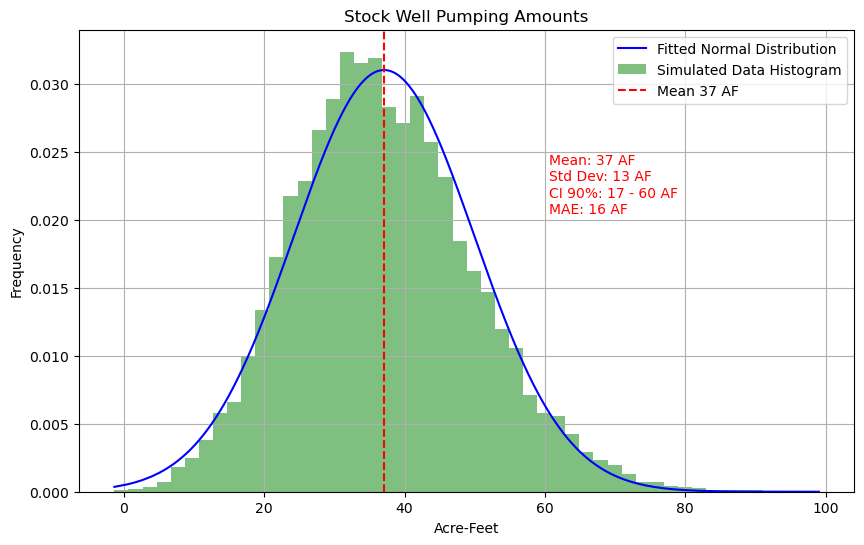

In [98]:
well = gpd.read_file("gis_files/well_siteid.gpkg")
well['USES'] = well['USES'].str.strip()
stwell = well[well['USES']=='S']
stwellcnt = stwell['USES'].count()
mean_dur = 30*24*60
std_dur = 5*24*60
duration = stats.norm(loc=mean_dur, scale=std_dur)

mean_pump = 10
std_pump = 3
pump = stats.norm(loc=mean_pump, scale=std_pump)

simulated_stock_amt = duration.rvs(size=10000)* stwellcnt * pump.rvs(size=10000) * 3.06889e-6
stock_amt_fit = stats.norm.fit(simulated_stock_amt)
pdf_stock_amt = stats.norm.pdf(np.sort(simulated_stock_amt), *stock_amt_fit)
plt.figure(figsize=(10,6))
plt.plot(np.sort(simulated_stock_amt), pdf_stock_amt, label='Fitted Normal Distribution', color='blue')
plt.hist(simulated_stock_amt, bins=50, density=True, color='green', alpha=0.5, label='Simulated Data Histogram')
plt.xlabel("Acre-Feet")
plt.ylabel("Frequency")
plt.title("Stock Well Pumping Amounts")
plt.axvline(x=simulated_stock_amt.mean(), color='red', linestyle='--', label=f'Mean {simulated_stock_amt.mean():.0f} AF')
plt.text(simulated_stock_amt.mean()+23.5, 0.0205, f'Mean: {simulated_stock_amt.mean():.0f} AF\nStd Dev: {np.std(simulated_stock_amt):.0f} AF\nCI 90%: {np.percentile(simulated_stock_amt, 5):.0f} - {np.percentile(simulated_stock_amt, 95):.0f} AF\nMAE: {np.std(simulated_stock_amt)*np.sqrt(np.pi/2):.0f} AF', color='red')
plt.legend()
plt.grid()

## Total Domestic Pumping Estimate

In [79]:
total_yard_acres = gpd.read_file("gis_files/zonal_table.geojson")['acres'].sum()

ppt_fil = pd.read_csv("output_tables/milford_dly_precip.csv")
ppt_fil['datetime'] = pd.to_datetime(ppt_fil['date_time'])
ppt_fil['year'] = ppt_fil['datetime'].dt.year
ppt_fil['month'] = ppt_fil['datetime'].dt.month
ppt_fil = ppt_fil[(ppt_fil['year']>=2000)&(ppt_fil['month'].isin([3,4,5,6,7,8,9,10]))]
ppt_fil_sum = ppt_fil.groupby('year').sum(numeric_only=True)['precip_wpg']
ppt_ft = ppt_fil_sum/12
ppt_ft.round(2)

year
2021    0.35
2022    0.26
2023    0.37
2024    0.33
2025    0.34
Name: precip_wpg, dtype: float64

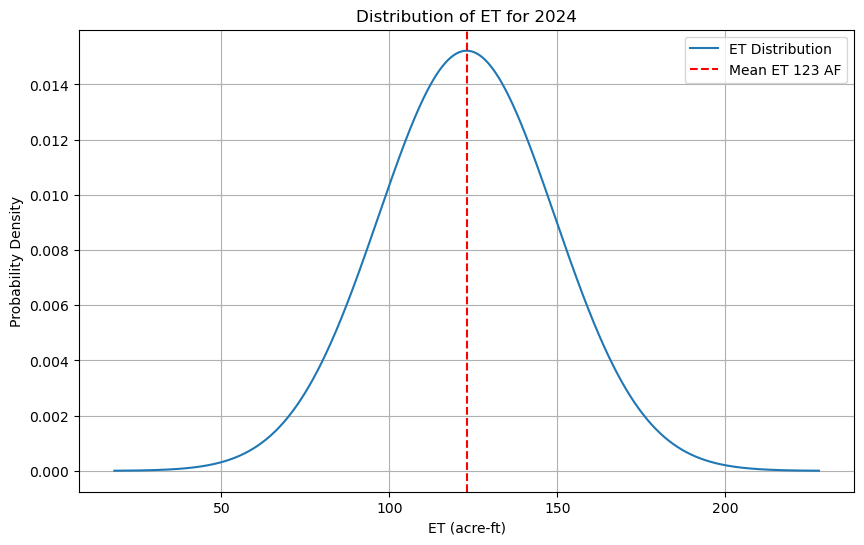

In [82]:
yards = pd.read_csv("output_tables/Yard_Zonal.csv")
yards['datetime'] = pd.to_datetime(yards['datetime'])
yards['year'] = yards['datetime'].dt.year
yards['month'] = yards['datetime'].dt.month
yards = yards[(yards['year']>=2000)&(yards['month'].isin([3,4,5,6,7,8,9,10]))]


total_et_yrds = yards.groupby(['year','band']).sum(numeric_only=True)['acre_ft'].unstack(-1).round(0)['et_ensemble_mad']

et_yrds_mean = total_et_yrds.loc[2024]
mae = np.sum(et_yrds_mean)*0.17
sigma = mae * np.sqrt(np.pi / 2)
oet_yrd_dist = stats.norm(loc=et_yrds_mean, scale=sigma)

plt.figure(figsize=(10,6))
x = np.linspace(et_yrds_mean - 4*sigma, et_yrds_mean + 4*sigma, 1000)
pdf = oet_yrd_dist.pdf(x)
plt.plot(x, pdf, label='ET Distribution')
plt.axvline(x=et_yrds_mean, color='red', linestyle='--', label=f'Mean ET {et_yrds_mean:.0f} AF')
plt.xlabel('ET (acre-ft)')
plt.ylabel('Probability Density')
plt.title('Distribution of ET for 2024')
plt.legend()
plt.grid(True)

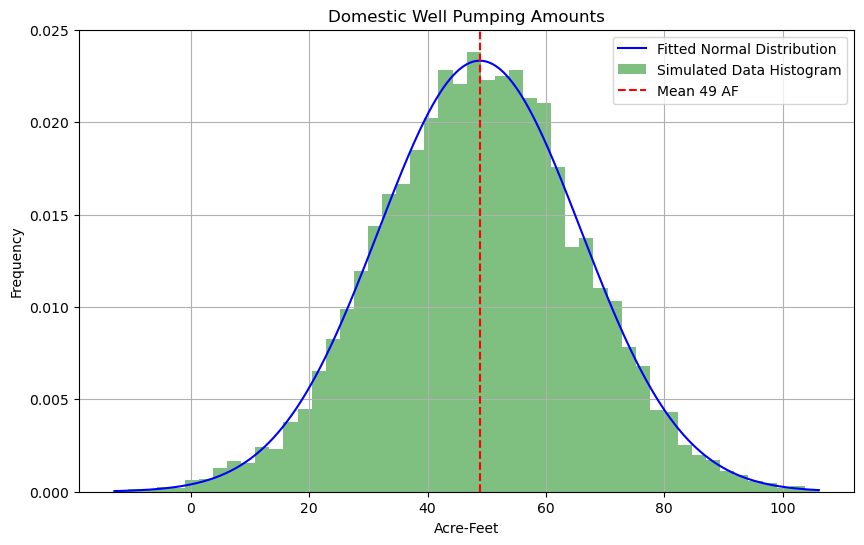

In [62]:
well = gpd.read_file("gis_files/well_siteid.gpkg")

dom_use_types = []
for use in well['USES'].unique():
    if use and 'D' in use:
        dom_use_types.append(use)

domwell = well[well['USES'].isin(dom_use_types)]
domwellcnt = domwell['USES'].count()
mean_amt = 573 # gallons per day per well
std_amt = 200
amount = stats.norm(loc=mean_amt, scale=std_amt)

simulated_dom_amt = amount.rvs(size=10000) * domwellcnt * 3.06889e-6 * 365.25
dom_amt_fit = stats.norm.fit(simulated_dom_amt)
pdf_dom_amt = stats.norm.pdf(np.sort(simulated_dom_amt), *dom_amt_fit)
plt.figure(figsize=(10,6))
plt.plot(np.sort(simulated_dom_amt), pdf_dom_amt, label='Fitted Normal Distribution', color='blue')
plt.hist(simulated_dom_amt, bins=50, density=True, alpha=0.5, color='green', label='Simulated Data Histogram')
plt.xlabel("Acre-Feet")
plt.ylabel("Frequency")
plt.title("Domestic Well Pumping Amounts")
plt.axvline(x=simulated_dom_amt.mean(), color='red', linestyle='--', label=f'Mean {simulated_dom_amt.mean():.0f} AF')
plt.legend()
plt.grid()

CI 90%: 120 - 224 AF
MAE : 39 AF


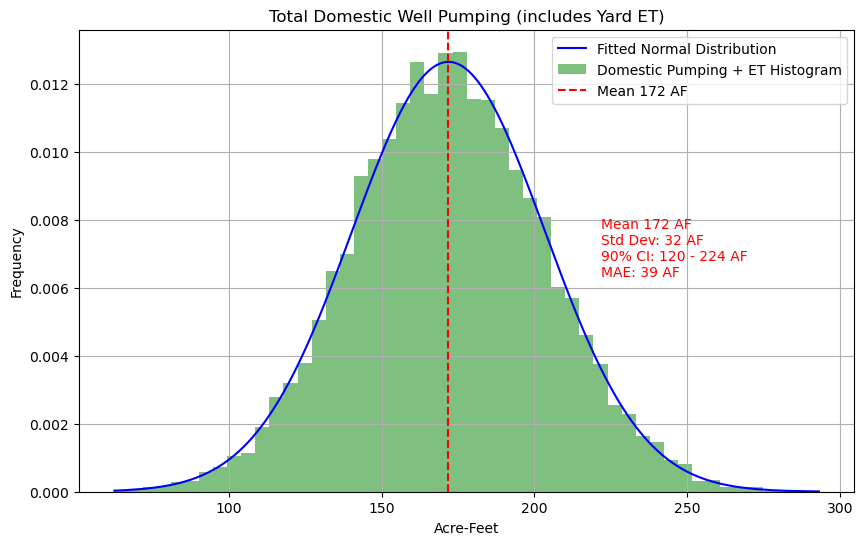

In [99]:
total_dom_pumpin = oet_yrd_dist.rvs(size=10000) + simulated_dom_amt
total_dom_pumpin_fit = stats.norm.fit(total_dom_pumpin)
pdf_total_dom_pumpin = stats.norm.pdf(np.sort(total_dom_pumpin), *total_dom_pumpin_fit)
plt.figure(figsize=(10,6))  
plt.plot(np.sort(total_dom_pumpin), pdf_total_dom_pumpin, label='Fitted Normal Distribution', color='blue')
plt.hist(total_dom_pumpin, bins=50, density=True, color='green', alpha=0.5, label='Domestic Pumping + ET Histogram')
plt.xlabel("Acre-Feet")
plt.ylabel("Frequency")
plt.title("Total Domestic Well Pumping (includes Yard ET)")

plt.axvline(x=total_dom_pumpin.mean(), color='red', linestyle='--', label=f'Mean {total_dom_pumpin.mean():.0f} AF')

print(f"CI 90%: {np.percentile(total_dom_pumpin, 5):.0f} - {np.percentile(total_dom_pumpin, 95):.0f} AF")
print(f"MAE : {np.std(total_dom_pumpin)*np.sqrt(np.pi/2):.0f} AF")
plt.text(total_dom_pumpin.mean()+50, max(pdf_total_dom_pumpin)/2,
         f'Mean {total_dom_pumpin.mean():.0f} AF\nStd Dev: {np.std(total_dom_pumpin):.0f} AF\n90% CI: {np.percentile(total_dom_pumpin, 5):.0f} - {np.percentile(total_dom_pumpin, 95):.0f} AF\nMAE: {np.std(total_dom_pumpin)*np.sqrt(np.pi/2):.0f} AF', color='red')
plt.legend()
plt.grid()

# Bring in Canal Data

In [65]:
res_q = pd.read_csv("output_tables/res_discharge.csv")
res_q['Date'] = pd.to_datetime(res_q['Date'])
res_q.set_index('Date', inplace=True)
res_q['beaver_acft'] = res_q['Flume Discharge (cfs)']*1.98347 # convert cfs to acre-ft/day
res_q = res_q.drop(columns=['Flume Discharge (cfs)','Notes'])

res_q = res_q.resample('D').asfreq().interpolate() # daily frequency with interpolation for data gaps
res_q_monthly = res_q.resample('ME').sum()
res_q_yearly = res_q.resample('YE').sum()
res_q_yearly['year'] = res_q_yearly.index.year
res_q_yearly.set_index('year', inplace=True)
res_q_yearly

beav_q= pd.read_csv("output_tables/beaver_at_rocky_ford_dam.txt",parse_dates={'Date':[0,1,2]},index_col='Date')
beav_q['beaver_acft'] = beav_q['Discharge in CFS']*1.98347
beav_q = beav_q.resample('D').asfreq().interpolate()
beav_q_yearly = beav_q.resample('YE').sum()
beav_q_yearly['year'] = beav_q_yearly.index.year
beav_q_yearly.set_index('year', inplace=True)
beav_q_yearly = beav_q_yearly.drop(columns=['Discharge in CFS'],axis=1).round(0)
beav = pd.concat([beav_q_yearly, res_q_yearly], axis=0).dropna().round(0)#.to_frame()
beav = beav.loc[1914:]

utopia = pd.read_csv("output_tables/utopia.csv",parse_dates=[0],index_col='Date').drop(['Notes'],axis=1)
flat = pd.read_csv("output_tables/flat.csv",parse_dates=[0],index_col='Date').drop(['Notes'],axis=1)
flat['flat_acft'] = flat['Discharge (cfs)']*1.98347
utopia['utopia_acft'] = utopia['Discharge (cfs)']*1.98347
flat = flat.drop(['Discharge (cfs)'],axis=1)
utopia = utopia.drop(['Discharge (cfs)'],axis=1)
all_canals = pd.concat([res_q,flat,utopia],axis=1)
all_canals['minersville_acft'] = all_canals['utopia_acft'] + all_canals['flat_acft']
all_canals['milford_acft'] = all_canals['beaver_acft'] - all_canals['minersville_acft']



/var/folders/jg/b66w1nm54nj99vk_9vx8vntr0000gn/T/ipykernel_48631/573477297.py:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  beav_q= pd.read_csv("output_tables/beaver_at_rocky_ford_dam.txt",parse_dates={'Date':[0,1,2]},index_col='Date')


Text(0, 0.5, 'Minersville Dam Release (ac-ft/yr)')

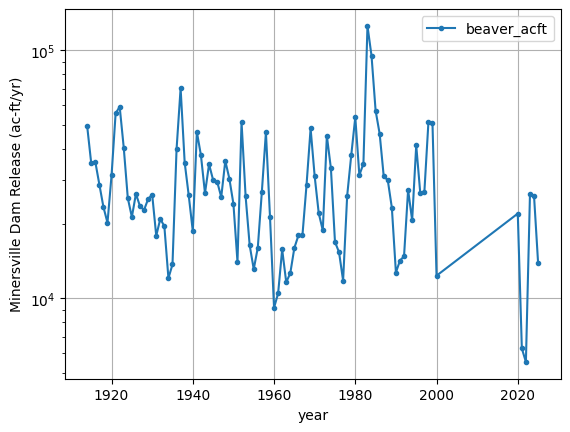

In [66]:
beav.plot(marker=".")
plt.grid()
plt.yscale('log')
plt.ylabel('Minersville Dam Release (ac-ft/yr)')

(-10.0, 500.0)

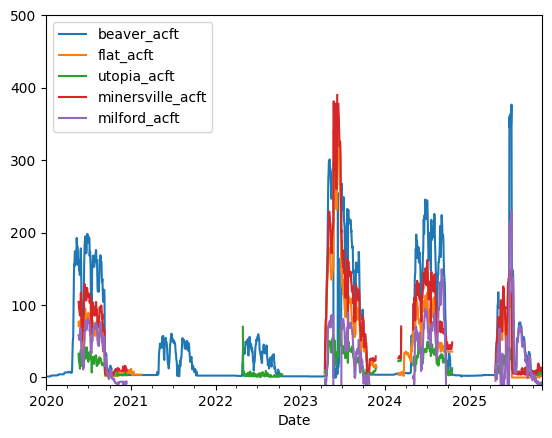

In [67]:
all_canals.plot()
plt.ylim(-10,500)

# Estimate Infilration

Irrigation pumping Estimates from USGS (https://warcapps.usgs.gov/gs-water/uwsc/ugcwa)

In [50]:
usgs_irr = {1990: 41000,
            1991: 47500,
            1992: 35400,
            1993: 44700,        
            1994: 52400,
            1995: 46200,
            1996: 44600,
            1997: 45000,
            1998: 32700,
            1999: 31800,
            2000: 39600,
            2001: 33500,
            2002: 42500,
            2003: 40300,
            2004: 35800,
            2005: 31400,
            2006: 36400,
            2007: 40600,
            2008: 40300,
            2009: 45600,
            2010: 41100,
            2011: 32200,
            2012: 44700,
            2013: 45900,
            2014: 45700,
            2015: 44900,
            2016: 45000,
            2017: 46800,
            2018: 59584,
            2019: 39912,
            2020: 46863,
            2021: 47423,
            2022: 52662,
            2023: 38735,
            }

np.float64(13879.0)

Slope: -0.25041701619408513
Intercept: 49089.565130178176
R-squared: 0.31480291560831414
P-value: 0.02954972851451989
Standard Error: 0.10246617875402374


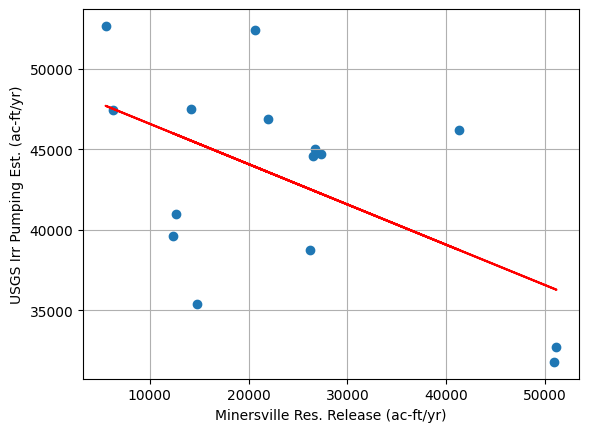

In [68]:
beav_vals = []
usgs_vals = []
for ind in beav.index:
    if ind in usgs_irr.keys():
        beav_vals.append(beav.loc[ind,'beaver_acft'])
        usgs_vals.append(np.float64(usgs_irr[ind]))

beav_vals = np.array(beav_vals)
usgs_vals = np.array(usgs_vals)
slope, intercept, r_value, p_value, std_err = stats.linregress(beav_vals, usgs_vals)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


plt.scatter(beav_vals, usgs_vals)
plt.plot(beav_vals, slope * beav_vals + intercept, color='red', label='Regression Line')
plt.xlabel('Minersville Res. Release (ac-ft/yr)')
plt.ylabel('USGS Irr Pumping Est. (ac-ft/yr)')

plt.grid()

In [69]:
fields = gpd.read_file("gis_files/pou_oet_consumed_1991_2025.gpkg")
fields = fields.rename(columns=lambda x: int(x.replace("consumed_", "")) if "consumed_" in x else x)

lat_threshold = 38.25
value_to_assign_s = "minersville"
value_to_assign_n = "milford_flat"

mask = fields.geometry.centroid.y < lat_threshold
fields.loc[mask, "irr_area"] = value_to_assign_s

maskn = fields.geometry.centroid.y > lat_threshold
fields.loc[maskn, "irr_area"] = value_to_assign_n

print(fields.columns)

app = pd.read_csv(raw_fold / "Milford_OpenET/applied_water_out/masked_et_pr_applied_acrefeet_summary.csv")
app['month'] = pd.to_datetime(app['month'])
app.set_index('month', inplace=True)
app = app[app.index.month.isin([4,5,6,7,8,9,10])]
appyr = app.groupby(app.index.year).sum()
appyrdict = appyr['applied_acre_feet_masked'].to_dict()

applied = fields.groupby(['WaterSourc'])[list(range(1990,2026))].sum().T
applied['GW + Mixed']= applied['GW'] + applied['Mix']*0.75 #account for mix
for year in applied.index:
    if year in beav.index:
        if beav.loc[year,'beaver_acft'] > 22000:
            applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW']
        elif beav.loc[year,'beaver_acft'] < 5000:
            applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW'] + applied.loc[year,'Mix']
        else:
            applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW'] + applied.loc[year,'Mix']*0.8
    else:
        applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW'] + applied.loc[year,'Mix']*0.8


applied['usgs'] = applied.index.map(lambda x: usgs_irr.get(x))

applied['infiltration'] = applied['usgs'] - applied['GW + Mixed']
applied['ratio'] = np.where(applied['infiltration'] / applied['usgs'] > 0.05, applied['infiltration'] / applied['usgs'], np.nan)
applied['whole_raster_consumed'] = applied.index.map(lambda x: appyrdict.get(x))
applied.round(2)


Index(['GROUP_NUMB',        'URL',      'ACRES',     'WRNUMS',      'dbURL',
         'recordID',    'FieldNo', 'WaterSourc',   'FARMNAME',     'qtywtr',
            'accID',    'Acnt_no',   'field_id', 'field_id_L', 'Shape_Leng',
       'Shape_Area',   'match_id',         1990,         1991,         1992,
               1993,         1994,         1995,         1996,         1997,
               1998,         1999,         2000,         2001,         2002,
               2003,         2004,         2005,         2006,         2007,
               2008,         2009,         2010,         2011,         2012,
               2013,         2014,         2015,         2016,         2017,
               2018,         2019,         2020,         2021,         2022,
               2023,         2024,         2025,   'geometry',   'irr_area'],
      dtype='object')


WaterSourc,GW,Mix,SW,GW + Mixed,usgs,infiltration,ratio,whole_raster_consumed
1990,24278.41,6678.52,5327.27,29621.22,41000.0,11378.78,0.28,47429.53
1991,24318.18,6126.60,5237.18,29219.46,47500.0,18280.54,0.38,48963.75
1992,25423.24,6980.73,5515.10,31007.82,35400.0,4392.18,0.12,57996.05
1993,27262.95,7731.35,6629.36,27262.95,44700.0,17437.05,0.39,65790.98
1994,28947.73,7550.38,6009.95,34988.03,52400.0,17411.97,0.33,55485.42
1995,22721.30,6168.61,5214.03,22721.30,46200.0,23478.70,0.51,39788.69
1996,27420.08,7592.60,6381.19,27420.08,44600.0,17179.92,0.39,54080.04
1997,23176.84,6818.81,5565.74,23176.84,45000.0,21823.16,0.48,47823.63
1998,21633.65,6528.35,5129.58,21633.65,32700.0,11066.35,0.34,39694.65
1999,21680.91,6447.91,5156.71,21680.91,31800.0,10119.09,0.32,41561.33


KS statistic=0.0776, p=0.9796
(np.float64(0.2611756657625031), np.float64(0.10956370794775665))
Mean: 0.2611756657625031, Variance: 0.012004206099261313
Std Err: 0.019072593457360138
MAE: 0.09021625048919604
0.18172395129469976 [0.524 0.597 0.717 0.836 0.994]


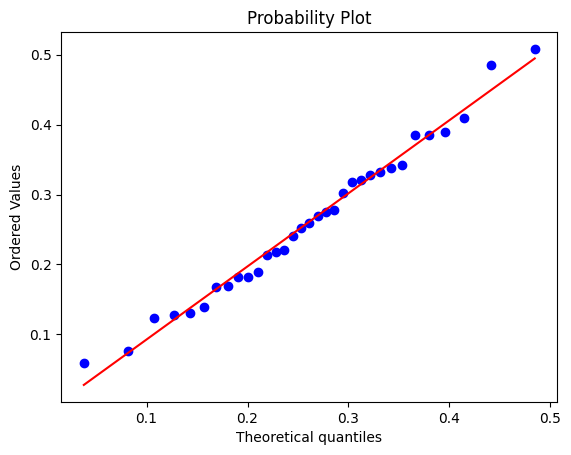

In [70]:
data = applied['ratio'].dropna()
params = stats.norm.fit(data)
D, p = stats.kstest(data, 'norm', args=params)
print(f"KS statistic={D:.4f}, p={p:.4f}")
print(params)

best_fit = stats.norm(*params)
mean, var = best_fit.stats(moments='mv')
print(f"Mean: {mean}, Variance: {var}")
print(f"Std Err: {np.sqrt(var/len(data))}")
print(f"MAE: {np.mean(np.abs(data - mean))}")
result = stats.anderson(data, dist='norm')
print(result.statistic, result.critical_values)


x = np.linspace(data.min(), data.max(), 100)
pdf_fitted = stats.norm.pdf(x, *params)

stats.probplot(data, dist=stats.norm, sparams=params, plot=plt)
plt.show()

1990
Diversion estimate: 51922 acre-ft
Error 37.93% = 19694 acre-ft
CI: 25530 to 87652
Minersville discharge: 12696 acre-ft ± 1270 acre-ft
Irrigation pumping estimate: 44229 acre-ft
USGS estimate: 41000 acre-ft
Error 41.02% = 18145 acre-ft
CI: 20467 to 77342
0.4102486597756237
1991
Diversion estimate: 51060 acre-ft
Error 37.93% = 19367 acre-ft
CI: 25106 to 86197
Minersville discharge: 14183 acre-ft ± 1418 acre-ft
Irrigation pumping estimate: 41881 acre-ft
USGS estimate: 47500 acre-ft
Error 42.12% = 17640 acre-ft
CI: 18865 to 74094
0.42118324402776824
1992
Diversion estimate: 54261 acre-ft
Error 37.93% = 20581 acre-ft
CI: 26680 to 91601
Minersville discharge: 14764 acre-ft ± 1476 acre-ft
Irrigation pumping estimate: 44503 acre-ft
USGS estimate: 35400 acre-ft
Error 42.22% = 18790 acre-ft
CI: 19978 to 78798
0.42221468899431747
1993
Diversion estimate: 59563 acre-ft
Error 37.93% = 22592 acre-ft
CI: 29287 to 100551
Minersville discharge: 27331 acre-ft ± 2733 acre-ft
Irrigation pumping estim

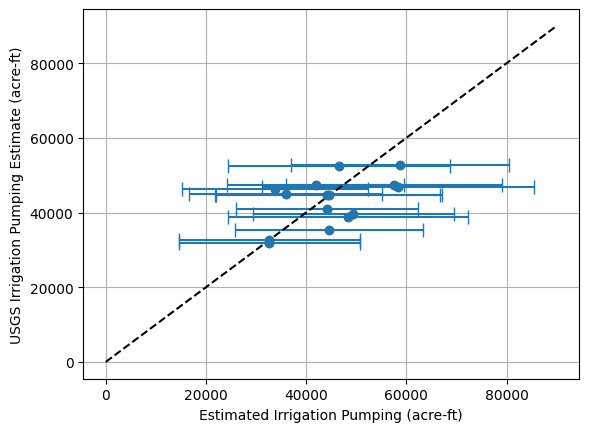

In [71]:
# Randomly sample 10000 infiltration percentage values (with replacement is implicit)
data = applied['ratio'].dropna()
params = stats.norm.fit(data)
samples = stats.norm.rvs(*params, size=10000, random_state=42)
infil_dist = stats.norm(*params)

yrly_data = {}
yrs = [1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2020,2021,2022,2023,2024]
for year in yrs:
    print(f"{year}")



    # Now model OET consumption uncertainty as normal with MAE = 17% of consumption based on Volk et al. Uncertainty of 17%
    mae = np.sum(fields[year])*0.17
    sigma = mae * np.sqrt(np.pi / 2)
    oet_dist = stats.norm(loc=np.sum(fields[year]), scale=sigma)

    # Now combine the two distributions to estimate diversion uncertainty
    divers_samples = oet_dist.rvs(size=10000,random_state=42)/(1-infil_dist.rvs(size=10000, random_state=42)) 
    divers_params = stats.norm.fit(divers_samples)
    print(f"Diversion estimate: {np.mean(divers_samples):.0f} acre-ft")
    print(f"Error {np.std(divers_samples)/np.mean(divers_samples)*100:.2f}% = {np.mean(divers_samples)*np.std(divers_samples)/np.mean(divers_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(divers_samples, 5):.0f} to {np.percentile(divers_samples, 95):.0f}")

    mae_minersville = beav.loc[year,'beaver_acft']*0.10
    sigma_minersville = mae_minersville * np.sqrt(np.pi / 2)
    print(f"Minersville discharge: {beav.loc[year,'beaver_acft']:.0f} acre-ft ± {mae_minersville:.0f} acre-ft")
    minersville_dist = stats.norm(loc=beav.loc[year,'beaver_acft'], scale=sigma_minersville)
    beav_q_samples = minersville_dist.rvs(size=10000,random_state=42) - 5000 # subtract seepage loss
    irr_pumping_samples = divers_samples - np.where(beav_q_samples<15000,beav_q_samples,15000)
    irr_pumping_params = stats.norm.fit(irr_pumping_samples)
    print(f"Irrigation pumping estimate: {np.mean(irr_pumping_samples):.0f} acre-ft")
    if year<2024:
        print(f"USGS estimate: {usgs_irr[year]:.0f} acre-ft")
    print(f"Error {np.std(irr_pumping_samples)/np.mean(irr_pumping_samples)*100:.2f}% = {np.mean(irr_pumping_samples)*np.std(irr_pumping_samples)/np.mean(irr_pumping_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(irr_pumping_samples, 5):.0f} to {np.percentile(irr_pumping_samples, 95):.0f}")
    print(np.std(irr_pumping_samples)/np.mean(irr_pumping_samples))

    pump_diff = np.mean(irr_pumping_samples) - usgs_irr.get(year, np.nan)
    yrly_data[year] = pd.Series({
        'diversion_mean': np.mean(divers_samples),
        'diversion_std': np.std(divers_samples),
        'irr_pumping_mean': np.mean(irr_pumping_samples),
        'irr_pumping_std': np.std(irr_pumping_samples),
        'USGS_irr': usgs_irr.get(year, np.nan),
        'pump_diff': pump_diff,
        'Minersville_discharge': beav.loc[year,'beaver_acft']
        })

yrly_df = pd.DataFrame(yrly_data).T
yrly_df.round(0)


pumpest = yrly_df[['irr_pumping_mean','USGS_irr']].dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(pumpest['irr_pumping_mean'], 
                                                               pumpest['USGS_irr'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")
print(np.round((pumpest['irr_pumping_mean']-pumpest['USGS_irr']).abs().mean(),0))

plt.plot(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'], 'o',color='orange')
plt.errorbar(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'],
             xerr=yrly_df['irr_pumping_std'], fmt='o', capsize=5)
plt.xlabel("Estimated Irrigation Pumping (acre-ft)")
plt.ylabel("USGS Irrigation Pumping Estimate (acre-ft)")
plt.plot([0,90000],[0,90000],'k--')
plt.grid()
#plt.xlim(0,60000)

<Axes: >

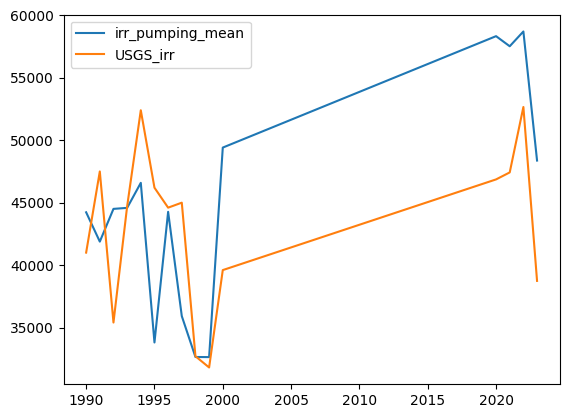

In [72]:
pumpest.plot()

In [ ]:
beavd = {1990: 12696.0,
            1991: 14183.0,
            1992: 14764.0,
            1993: 27331.0,
            1994: 20607.0,
            1995: 41321.0,
            1996: 26483.0,
            1997: 26743.0,
            1998: 51149.0,
            1999: 50898.0,
            2000: 12326.0,
            2020: 21939.0,
            2021: 6273.0,
            2022: 5536.0,
            2023: 26195.0,}

usgsd= {1990: 41000,
            1991: 47500,
            1992: 35400,
            1993: 44700,        
            1994: 52400,
            1995: 46200,
            1996: 44600,
            1997: 45000,
            1998: 32700,
            1999: 31800,
            2000: 39600,
            2020: 46863,
            2021: 47423,
            2022: 52662,
            2023: 38735,
            }
field = {1990: 36284.0,
            1991: 35682.0,
            1992: 37919.0,
            1993: 41624.0,
            1994: 42508.0,
            1995: 34104.0,
            1996: 41394.0,
            1997: 35561.0,
            1998: 33292.0,
            1999: 33286.0,
            2000: 39647.0,
            2020: 50974.0,
            2021: 41090.0,
            2022: 41402.0,
            2023: 44259.0,}

data = pd.concat([pd.Series(beavd),
           pd.Series(field),
           pd.Series(usgsd)],axis=1)

data.columns = ['minersville_release','consumptive_use','usgs_pumping']
data.dropna(inplace=True)




In [ ]:
import numpy as np

def mean_abs_residual(params, data):
    infiltration, max_beaver_use_for_crops, canal_loss = params
    
    # Guard against nonsense / division blow-up
    if not (0 < infiltration < 0.99):
        return 1e9
    
    total_diversion = data['consumptive_use'] / (1 - infiltration)
    
    # canal loss scales with minersville_release
    #canal_loss = canal_loss_frac * data['minersville_release']

    stream_diversion = np.where(data['minersville_release'] > max_beaver_use_for_crops,
        max_beaver_use_for_crops - canal_loss,
        data['minersville_release'] - canal_loss)
    
    well_diversion = total_diversion - stream_diversion
    residual = well_diversion - data['usgs_pumping']
    
    return np.mean(np.abs(residual))

from scipy.optimize import differential_evolution

# bounds: tune these based on what you think is physically plausible
bounds = [
    (0.21, 0.8),      # infiltration fraction
    (0, 30_000),  # max_beaver_use_for_crops (acre-ft or whatever units)
    (500, 10000)     # beaver_infiltration_in_canal
]

result = differential_evolution(
    mean_abs_residual,
    bounds=bounds,
    args=(data,),
    maxiter=400,
    tol=1e-6,
    seed=42,
    polish=True,
)

print("Success:", result.success)
print("Message:", result.message)
print("Optimized params [infiltration, max_beaver_use_for_crops, canal_loss]:")
print(result.x)
print("Minimized mean |residual|:", result.fun)



Success: True
Message: Optimization terminated successfully.
Optimized params [infiltration, max_beaver_use_for_crops, canal_loss]:
[2.10000110e-01 9.99600750e+03 2.00739252e+03]
Minimized mean |residual|: 4882.207758278138
